(35000, 21) (15000, 21)


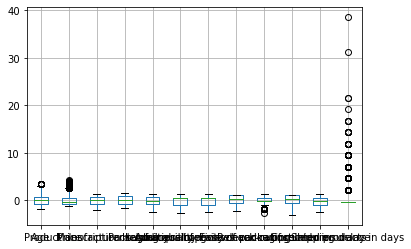

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

df = pd.read_csv("model.csv", sep = "," , index_col=0)

#df[df.duplicated()] --> No dublicate data found

#df.isnull().sum()   --> Some missing values were found
df = df.fillna(int(df.mean()[["Age"]])) 


# df.describe()                 \
# %matplotlib inline             ## Grapgh for to see the weight of the data
# df.boxplot( fontsize=5)       /


# df.describe()
# sns.boxplot(x=df["Price"] )      ## To check how the data is spreaded (Outliers)


# Separating the Catagorical data and the numerical data 
df_categorical=df.select_dtypes(include=['object'])
df_numerical=df.select_dtypes(include=[np.number])


# df_0=df_categorical[df['Satisfaction']=='Not Satisfied'] # records wih target==0
# df_1=df_categorical[df['Satisfaction']=='Satisfied'] # records wih target==1
# fig, axes = plt.subplots(2, 5,figsize=[15,6])
# axes = axes.flatten()
# fig.tight_layout(pad=2)                                                          ## Plots and compares the sa

# i=0
# for x in df_categorical.columns:
#     plt.sca(axes[i]) # set the current Axes
#     plt.hist([df_0[x],df_1[x]],density=True , )
#     plt.title(x)
#     i+=1
# plt.show()



selection_categorical=['Gender', 'Customer Type', 'Category']

dummies = pd.get_dummies(df_categorical[selection_categorical]) 
#df_hist=df_numerical.hist(layout=(4,4), figsize=(15,12))
df_selection_numerical = df_numerical

from sklearn.preprocessing import StandardScaler

independent_variables=df_selection_numerical.iloc[:,:-1] #no target

scaler = StandardScaler().fit(independent_variables) # No target
scaled_df = pd.DataFrame(scaler.transform(independent_variables))
scaled_df.columns = independent_variables.columns


# Save the scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))
scaled_df.boxplot()

X_numerical=scaled_df

dummies.tail()

X=pd.concat([dummies,X_numerical], axis = 1)
X

satisfied = pd.get_dummies(df['Satisfaction'],drop_first=True)  
y=satisfied['Satisfied']
y.shape

from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30, #by default is 75%-25%
                                                    stratify=y, #preserve target propotions 
                                                    random_state= 321) #fix random seed for replicability

print(X_train.shape, X_test.shape)


def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) )) 
    print("precision  train %.3f   test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))

    
def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr)
        





<AxesSubplot:xlabel='Price'>

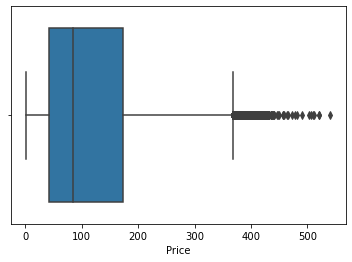

In [4]:
sns.boxplot(x=df["Price"] )

In [15]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(5,1000,5)}

hyperp_search(classifier,parameters)

f1_train: 0.787580 using {'n_neighbors': 15}
f1         train 0.816   test 0.792
precision  train 0.868   test 0.843

[[7997  852]
 [1563 4588]]


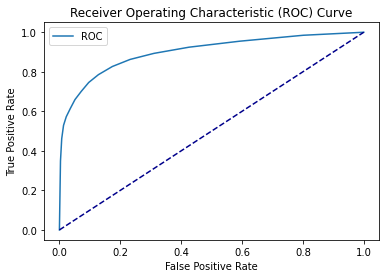

AUC: 0.90


In [16]:
model_knn = KNeighborsClassifier(n_neighbors=15)

fpr1,tpr1=roc(model_knn,X_train,y_train,X_test,y_test)

In [31]:
#Tree

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [2,4,5,6,8,10,12],
              'min_samples_split': [5,10,20,30,40],
              'min_samples_leaf': [5,10,20,30,40]}

hyperp_search(classifier,parameters)


f1_train: 0.775226 using {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 40}
f1         train 0.821   test 0.785
precision  train 0.869   test 0.829

[[7906  943]
 [1570 4581]]


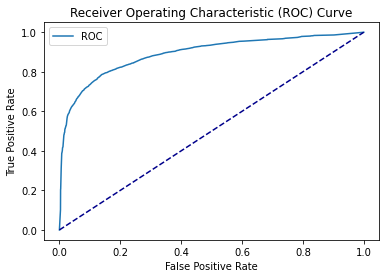

AUC: 0.89


In [33]:
model_tree = DecisionTreeClassifier(criterion='gini', max_depth=12, min_samples_leaf=5, min_samples_split=40)

fpr2,tpr2=roc(model_tree,X_train,y_train,X_test,y_test)


In [17]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)

from sklearn.metrics import f1_score
print("f1_score: ", f1_score(y_test, y_pred))

print("f1_test: ", f1_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_score:  0.685099846390169
f1_test:  0.685099846390169
[[6440 2409]
 [1691 4460]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      8849
           1       0.65      0.73      0.69      6151

    accuracy                           0.73     15000
   macro avg       0.72      0.73      0.72     15000
weighted avg       0.73      0.73      0.73     15000



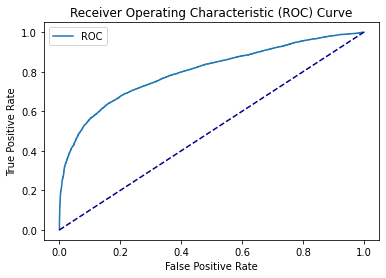

AUC: 0.80


In [18]:
y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr3,tpr3=roc(model,X_train,y_train,X_test,y_test)


In [28]:
# Logistic

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "max_iter":[1000] }


hyperp_search(classifier,parameters)


f1_train: 0.704480 using {'C': 1, 'max_iter': 1000}
f1         train 0.705   test 0.707
precision  train 0.748   test 0.751

[[7487 1362]
 [2047 4104]]


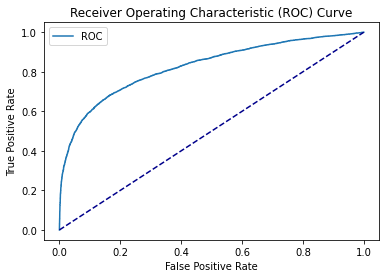

AUC: 0.83


In [30]:
model = LogisticRegression(C=1, max_iter=1000)

fpr4,tpr4=roc(model,X_train,y_train,X_test,y_test)


In [21]:
model.fit(X_train,y_train)

coeff=pd.DataFrame()
coeff["feature"]=X_train.columns
coeff["w"]=model.coef_[0]

coeff.sort_values(by=['w'], inplace=True)

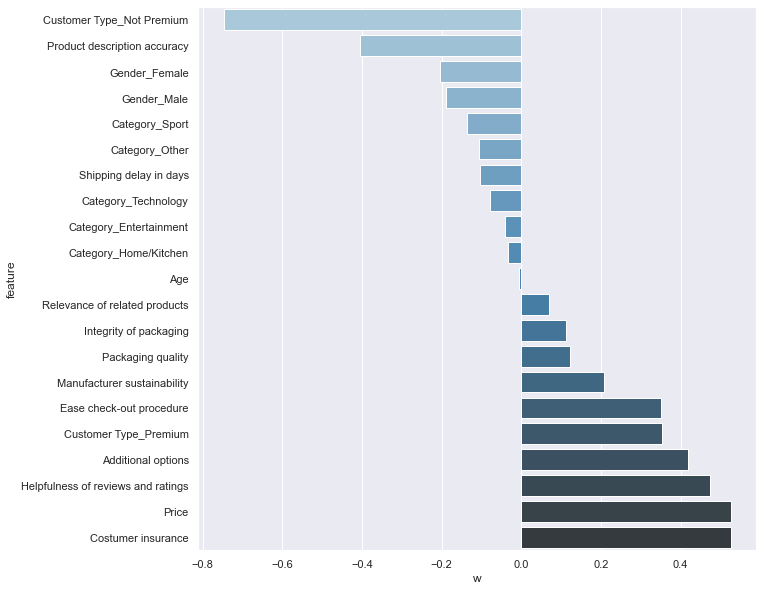

In [22]:
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(data=coeff, y="feature", x="w", palette="Blues_d", orient="h")
sns.set(rc={'figure.figsize':(6,4)})


In [ ]:
#SVM

from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','rbf','polinomial'], "C":[0.1,1,500],"gamma":[1], "degree":[2,3,4]}

hyperp_search(classifier,parameters)
# we had the f1 score but tried to re-run with different parameteres and we could not get the previous result!

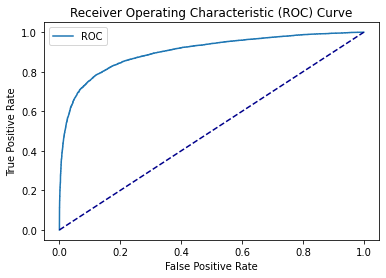

AUC: 0.90


In [7]:
model = SVC(C=50, kernel='rbf',probability=True)

fpr5,tpr5=roc(model,X_train,y_train,X_test,y_test)

In [42]:
# Multi-layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(40,30,20),[80,40,10], [100,50,40] ],  "max_iter": [2000], "alpha": [0.001,0.1]}

hyperp_search(classifier,parameters)

f1_train: 0.813640 using {'alpha': 0.1, 'hidden_layer_sizes': (40, 30, 20), 'max_iter': 2000}
f1         train 0.861   test 0.820
precision  train 0.912   test 0.870

[[8134  715]
 [1380 4771]]


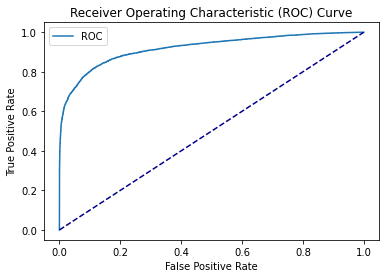

AUC: 0.92


In [41]:
model_MLP=MLPClassifier(hidden_layer_sizes=(40,30,20), alpha=0.1, max_iter=2000)

fpr6,tpr6=roc(model_MLP,X_train,y_train,X_test,y_test)